## Knowledge Distillation

--------

KL divergence between the teacher’s soft output probabilities \( q \) (produced with a temperature scaling) and the student’s output probabilities \( p \) is given by:


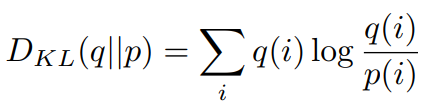
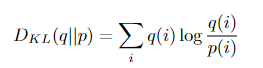

1. **Train the Teacher Model**: The teacher model is trained on the dataset using standard training procedures.
2. **Compute Soft Targets**: The teacher model’s output logits are converted into probabilities using a softmax function with temperature \( T \). These soft targets are softer versions of the original probabilities and contain more information about the relative similarities between classes.
3. **Train the Student Model**: The student model is trained using a combination of the traditional loss function (e.g., cross-entropy loss) and the KL divergence between the soft targets from the teacher and the student’s output probabilities.
4. **Loss Function**: The combined loss function can be represented as:

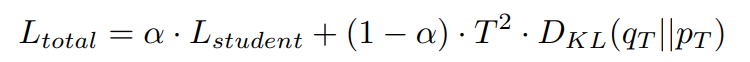

`L_student` is the cross-entropy loss of the student, `D_KL` is the KL divergence, `T` is the temperature, and `α` is a weighting factor.


-----

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

## CNN

Why train a model from scratch!

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [45]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=100, shuffle=True,num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=100,shuffle=False,num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


teacher Model - Epoch 1, Loss: 1.3741
teacher Model - Epoch 2, Loss: 0.9079
teacher Model - Epoch 3, Loss: 0.7046
teacher Model - Epoch 4, Loss: 0.5563
teacher Model - Epoch 5, Loss: 0.4347
teacher Model - Epoch 6, Loss: 0.3269
teacher Model - Epoch 7, Loss: 0.2324
teacher Model - Epoch 8, Loss: 0.1652
teacher Model - Epoch 9, Loss: 0.1238
teacher Model - Epoch 10, Loss: 0.1025
finished Training Teacher Model


c:\Users\smart\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


student model - epoch 1, loss: 0.2461 
student model - epoch 2, loss: 0.1754 
student model - epoch 3, loss: 0.1423 
student model - epoch 4, loss: 0.1208 
student model - epoch 5, loss: 0.1046 
student model - epoch 6, loss: 0.0906 
student model - epoch 7, loss: 0.0794 
student model - epoch 8, loss: 0.0678 
student model - epoch 9, loss: 0.0594 
student model - epoch 10, loss: 0.0498 
Finished Training Student Model


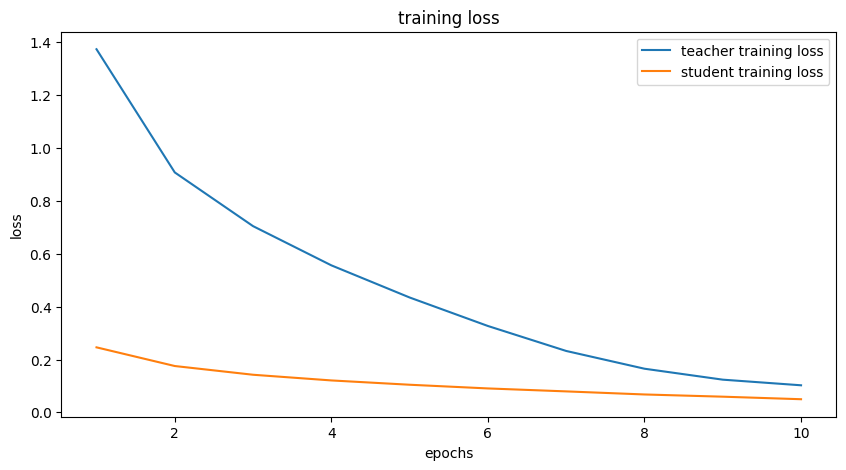

In [46]:
class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.conv1 =nn.Conv2d(3,64, 3,1,1)
        self.conv2=nn.Conv2d(64, 128,3,1,1)
        self.conv3=nn.Conv2d(128, 256,3,1, 1)
        self.pool= nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(256*4*4,256)
        self.fc2=nn.Linear(256,10)

    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        x= x.view(-1,256*4*4)
        x= F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
#total parameters of the teacher model : 1,423,242

teacher_model=TeacherNet().cuda()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(teacher_model.parameters(), lr=0.001)
teacher_train_losses=[]


for epoch in range(10):
    running_loss =0.0
    for i, data in enumerate(trainloader,0):
        inputs,labels=data
        inputs,labels = inputs.cuda(),labels.cuda()
        optimizer.zero_grad()
        outputs =teacher_model(inputs)
        loss =criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    average_loss =running_loss/len(trainloader)
    teacher_train_losses.append(average_loss)
    print(f'teacher Model - Epoch {epoch+1}, Loss: {average_loss:.4f}')
print('finished Training Teacher Model')

class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.conv1 =nn.Conv2d(3,32,3,1,1)
        self.conv2=nn.Conv2d(32,64,3,1,1)
        self.conv3=nn.Conv2d(64,128,3,1,1)
        self.pool=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(128*4*4,128)
        self.fc2=nn.Linear(128,10)

    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x= self.pool(F.relu(self.conv3(x)))
        x=x.view(-1,128*4*4)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x
    
#total parameters of student model : 356,810
#75% reduction of parameter size 

student_model=StudentNet().cuda()

def distillation_loss(student_outputs,teacher_outputs,labels,alpha=0.1,temperature=3):
    student_loss=criterion(student_outputs,labels)
    distillation_loss=nn.KLDivLoss()(F.log_softmax(student_outputs/temperature, dim=1),F.softmax(teacher_outputs/temperature, dim=1))
    return alpha*student_loss+(1-alpha)*distillation_loss
optimizer =optim.Adam(student_model.parameters(),lr=0.001)
student_train_losses=[]

for epoch in range(10):
    running_loss=0.0
    for i, data in enumerate(trainloader,0):
        inputs,labels=data
        inputs,labels=inputs.cuda(),labels.cuda()
        optimizer.zero_grad()
        teacher_outputs=teacher_model(inputs).detach()
        student_outputs= student_model(inputs)
        loss=distillation_loss(student_outputs,teacher_outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    average_loss=running_loss/len(trainloader)
    student_train_losses.append(average_loss)
    print(f'student model - epoch {epoch+1}, loss: {average_loss:.4f} ')

print('Finished Training Student Model')
epochs=range(1,11)
plt.figure(figsize=(10,5))
plt.plot(epochs,teacher_train_losses,label='teacher training loss')
plt.plot(epochs,student_train_losses,label='student training loss')
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## NLP

In [15]:
!pip install torch torchvision transformers datasets


[notice] A new release of pip available: 22.3 -> 24.1.1


[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt


dataset=load_dataset('imdb')
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):return tokenizer(examples['text'],padding='max_length',truncation=True,max_length=128)
tokenized_datasets=dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format(type='torch',columns=['input_ids','attention_mask','label'])
train_dataset=tokenized_datasets['train']
test_dataset=tokenized_datasets['test']
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)


c:\Users\smart\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [29]:
class SimpleLSTM(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_dim):
        super(SimpleLSTM,self).__init__()
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.lstm=nn.LSTM(embedding_dim, hidden_dim,batch_first=True)
        self.fc=nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded=self.embedding(text)
        packed_embedded=nn.utils.rnn.pack_padded_sequence(embedded,text_lengths,batch_first=True, enforce_sorted=False)
        _,(hidden,_)=self.lstm(packed_embedded)
        hidden=hidden[-1]
        return self.fc(hidden)

vocab_size = len(tokenizer)
embedding_dim = 128
hidden_dim = 256
output_dim = 2

teacher_model = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, output_dim)
teacher_model = teacher_model.cuda()
student_model = SimpleLSTM(vocab_size, embedding_dim, 128, output_dim) 
student_model = student_model.cuda()


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)

def train_model(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss=0
    total_correct=0
    for batch in data_loader:
        input_ids=batch['input_ids'].to(device)
        attention_mask=batch['attention_mask'].to(device)
        labels =batch['label'].to(device)
        optimizer.zero_grad()
        text_lengths =attention_mask.sum(1).cpu()
        outputs=model(input_ids, text_lengths)
        loss=criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_correct+=(outputs.argmax(1)==labels).sum().item()
    return total_loss/len(data_loader),total_correct/len(data_loader.dataset)
teacher_train_losses = []
teacher_train_accuracies = []
for epoch in range(10):
    train_loss, train_acc = train_model(teacher_model, train_loader, criterion, optimizer, device='cuda')
    teacher_train_losses.append(train_loss)
    teacher_train_accuracies.append(train_acc)
    print(f'teacher model - epoch {epoch+1}, loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
print('Finished Training Teacher Model')


Teacher Model - Epoch 1, Loss: 0.6902, Accuracy: 0.5314
Teacher Model - Epoch 2, Loss: 0.6528, Accuracy: 0.6127
Teacher Model - Epoch 3, Loss: 0.4221, Accuracy: 0.8113
Teacher Model - Epoch 4, Loss: 0.2991, Accuracy: 0.8801
Teacher Model - Epoch 5, Loss: 0.2102, Accuracy: 0.9240
Teacher Model - Epoch 6, Loss: 0.1342, Accuracy: 0.9556
Teacher Model - Epoch 7, Loss: 0.0782, Accuracy: 0.9774
Teacher Model - Epoch 8, Loss: 0.0454, Accuracy: 0.9876
Teacher Model - Epoch 9, Loss: 0.0298, Accuracy: 0.9920
Teacher Model - Epoch 10, Loss: 0.0221, Accuracy: 0.9939
Finished Training Teacher Model


In [31]:
def distillation_loss(student_outputs, teacher_outputs, labels, alpha=0.1, temperature=3):
    student_loss = criterion(student_outputs, labels)
    distillation_loss = nn.KLDivLoss()(nn.functional.log_softmax(student_outputs / temperature, dim=1),nn.functional.softmax(teacher_outputs / temperature, dim=1))
    return alpha*student_loss+(1-alpha)*distillation_loss

optimizer = optim.Adam(student_model.parameters(), lr=0.001)
student_train_losses =[]
student_train_accuracies =[]

def train_student_model(student_model, teacher_model, data_loader, criterion, optimizer, device):
    student_model.train()
    teacher_model.eval()
    total_loss = 0
    total_correct = 0
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        text_lengths = attention_mask.sum(1).cpu()
        with torch.no_grad():
            teacher_outputs =teacher_model(input_ids, text_lengths)
        student_outputs =student_model(input_ids, text_lengths)
        loss = distillation_loss(student_outputs, teacher_outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss +=loss.item()
        total_correct +=(student_outputs.argmax(1)==labels).sum().item()
    
    return total_loss/len(data_loader),total_correct/len(data_loader.dataset)

for epoch in range(10):
    train_loss, train_acc = train_student_model(student_model, teacher_model, train_loader, criterion, optimizer, device='cuda')
    student_train_losses.append(train_loss)
    student_train_accuracies.append(train_acc)
    print(f'Student Model - Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

print('Finished Training Student Model')


Student Model - Epoch 1, Loss: 0.2562, Accuracy: 0.5211
Student Model - Epoch 2, Loss: 0.2491, Accuracy: 0.5803
Student Model - Epoch 3, Loss: 0.1712, Accuracy: 0.7788
Student Model - Epoch 4, Loss: 0.1110, Accuracy: 0.8652
Student Model - Epoch 5, Loss: 0.0790, Accuracy: 0.9080
Student Model - Epoch 6, Loss: 0.0525, Accuracy: 0.9430
Student Model - Epoch 7, Loss: 0.0342, Accuracy: 0.9654
Student Model - Epoch 8, Loss: 0.0219, Accuracy: 0.9799
Student Model - Epoch 9, Loss: 0.0163, Accuracy: 0.9859
Student Model - Epoch 10, Loss: 0.0132, Accuracy: 0.9897
Finished Training Student Model


In [32]:
def evaluate_model(model,data_loader,device):
    model.eval()
    total_correct=0
    with torch.no_grad():
        for batch in data_loader:
            input_ids=batch['input_ids'].to(device)
            attention_mask=batch['attention_mask'].to(device)
            labels =batch['label'].to(device)
            
            text_lengths = attention_mask.sum(1).cpu()
            outputs = model(input_ids,text_lengths)
            total_correct+=(outputs.argmax(1)==labels).sum().item()
    
    return total_correct/len(data_loader.dataset)

test_acc =evaluate_model(student_model, test_loader, device='cuda')
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.7937


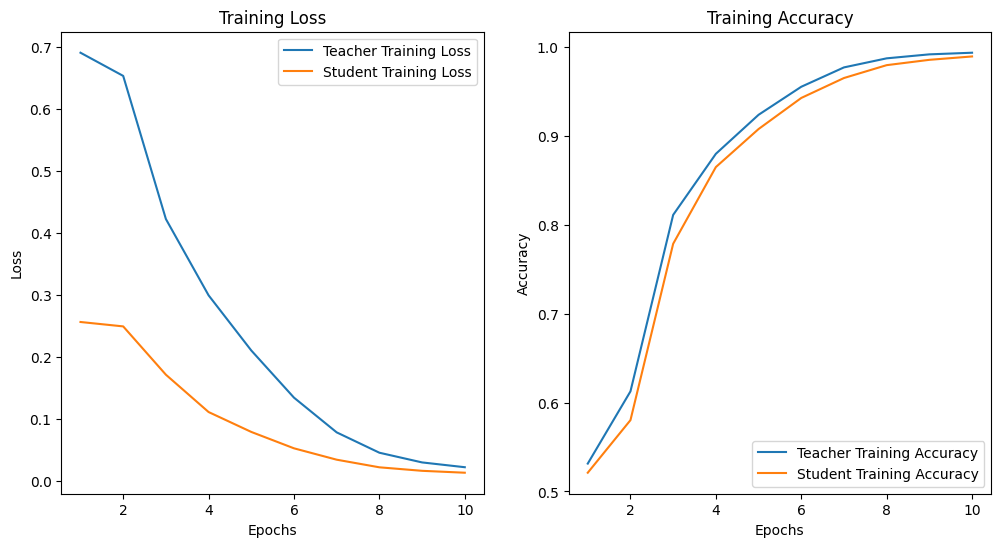

In [33]:
epochs = range(1, 11)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs,teacher_train_losses, label='Teacher Training Loss')
plt.plot(epochs, student_train_losses, label='Student Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, teacher_train_accuracies, label='Teacher Training Accuracy')
plt.plot(epochs, student_train_accuracies, label='Student Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
